# SWMM experiment procedure

## Steps
0. Calibrate tank and pipe sensors

1. Run an impulse through the system

2. Load impulse into SWMM as inflow hydrograph

3. Compare SWMM pipe depth with measured pipe depth

In [30]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import correlate

# UrbanSurge imports.
from urbansurge.swmm_model import SWMM
from urbansurge.data_acquisition import align_measurements, voltage_to_value
from urbansurge.data_acquisition import discrete_flow_series, flow_rate, flow_to_swmm_readable, mean_reading
from urbansurge.fault_diagnosis.moment_detection import moment_fault_detect

%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sensor Parameters

In [31]:
sensor_parameters = {
    'Sergei': {
        'calibration': {
            'b0': -0.0358,
            'b1': 0.801
        },
        'location': 'pipe',
    },
    'Louise': {
        'calibration': {
            'b0': 0.3208,
            'b1': 0.7624
        },
        'location': 'pipe',
    },
    'Ludwig': {
        'calibration': {
            'b0': -0.1124,
            'b1': 0.7839
        },
        'location': 'pipe',
    },
    'Tank': {
        'calibration': {
            'b0': 4.3401,
            'b1': 2.3017
        },
        'location': 'tank',
    },
}

## Load in experiment

#### Baseline and test experiments

In [32]:
# Load in experiment data.
experiment_dir = Path(r"sensor_data")

# List file names for easy copy-paste.
for fp in experiment_dir.glob('*.csv'):
    print(f'"{fp.name}",')

# Baseline files.
baseline_files = [
    "2025-02-01_19-28-43_sensor_data.csv",
    "2025-02-01_19-31-19_sensor_data.csv",
    "2025-02-01_19-33-36_sensor_data.csv",
    "2025-02-01_19-36-06_sensor_data.csv",
    "2025-02-01_19-38-22_sensor_data.csv",
    "2025-02-01_19-40-41_sensor_data.csv",
    "2025-02-01_19-42-41_sensor_data.csv",
    "2025-02-01_19-44-28_sensor_data.csv",
    "2025-02-01_19-46-06_sensor_data.csv",
    "2025-02-01_19-48-05_sensor_data.csv",
]

# Test files, valve 20% closed.
test_files_20 = [
    "2025-02-02_12-27-56_sensor_data.csv",
    "2025-02-02_12-34-12_sensor_data.csv",
    "2025-02-02_12-38-15_sensor_data.csv",
    "2025-02-02_12-40-45_sensor_data.csv",
]

# Test files, valve 40% closed.
test_files_40 = [
    "2025-02-02_12-45-24_sensor_data.csv",
    "2025-02-02_12-48-03_sensor_data.csv",
    "2025-02-02_12-52-22_sensor_data.csv",
    "2025-02-02_12-55-35_sensor_data.csv",
]

# Baseline data frames.
baseline_dfs = [pd.read_csv(experiment_dir / f) for f in baseline_files]
##baseline_dfs = baseline_dfs[baseline_dfs['longer_impulse'] == 0]

# Test data frames.
test_20_dfs = [pd.read_csv(experiment_dir / f) for f in test_files_20]
##test_20_dfs = test_20_dfs[test_20_dfs['longer_impulse'] == 0]
test_40_dfs = [pd.read_csv(experiment_dir / f) for f in test_files_40]
##test_40_dfs = test_40_dfs[test_40_dfs['longer_impulse'] == 0]

"2025-01-09_14-45-38_sensor_data.csv",
"2025-01-09_14-47-22_sensor_data.csv",
"2025-01-09_14-48-08_sensor_data.csv",
"2025-01-09_14-48-52_sensor_data.csv",
"2025-01-09_14-49-35_sensor_data.csv",
"2025-01-09_14-51-51_sensor_data.csv",
"2025-01-09_14-52-38_sensor_data.csv",
"2025-01-09_14-53-24_sensor_data.csv",
"2025-01-16_14-25-15_sensor_data.csv",
"2025-01-16_14-26-32_sensor_data.csv",
"2025-01-16_14-27-43_sensor_data.csv",
"2025-01-16_14-28-51_sensor_data.csv",
"2025-01-17_13-14-22_sensor_data.csv",
"2025-01-17_13-20-16_sensor_data.csv",
"2025-01-17_13-42-57_sensor_data.csv",
"2025-01-17_14-47-33_sensor_data.csv",
"2025-01-17_16-04-05_sensor_data.csv",
"2025-01-17_16-05-33_sensor_data.csv",
"2025-01-21_09-56-12_sensor_data.csv",
"2025-01-21_09-57-27_sensor_data.csv",
"2025-01-21_10-00-58_sensor_data.csv",
"2025-01-21_10-02-26_sensor_data.csv",
"2025-01-22_14-36-03_sensor_data.csv",
"2025-01-24_16-32-35_sensor_data.csv",
"2025-01-24_16-35-43_sensor_data.csv",
"2025-01-24_16-42-16_sens

#### Plot sensor readings

Text(0, 0.5, 'Voltage')

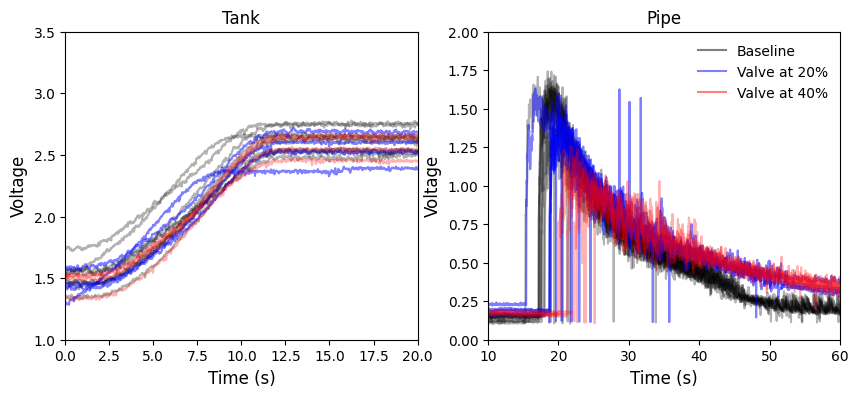

In [33]:
# Unaligned impulse and depth measurements.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai2'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax1.plot(df['time'], df['V_ai2'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax1.plot(df['time'], df['V_ai2'], 'r', alpha=0.3)

ax1.set_xlim(0, 20)
ax1.set_ylim(1, 3.5)
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Voltage', fontsize=12)

# Depth in pipe.
for df in baseline_dfs:
    ax2.plot(df['time'], df['V_ai1'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax2.plot(df['time'], df['V_ai1'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax2.plot(df['time'], df['V_ai1'], 'r', alpha=0.3)

# Legend plots.
ax2.plot([], [], 'k', alpha=0.5, label='Baseline')
ax2.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax2.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax2.legend(fontsize=10, frameon=False)

ax2.set_xlim(10, 60)
ax2.set_ylim(0, 2)
ax2.set_title('Pipe')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Voltage', fontsize=12)


#### Convert voltage to depth (tank)

In [34]:
# Tank measurements.
tank_sensor_name = 'Tank'
b0_tank = sensor_parameters[tank_sensor_name]['calibration']['b0']
b1_tank = sensor_parameters[tank_sensor_name]['calibration']['b1']

# Baseline data frames.
for df in baseline_dfs:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank

# Test data frames.
for df in test_20_dfs:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank

for df in test_40_dfs:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank

#### Convert voltage to depth (pipe)

In [35]:
# Pipe measurements.
pipe_sensor_name = 'Sergei'
b0 = sensor_parameters[pipe_sensor_name]['calibration']['b0']
b1 = sensor_parameters[pipe_sensor_name]['calibration']['b1']

# Baseline data frames.
for df in baseline_dfs:
    # Voltage.
    V = df['V_ai1'].to_numpy()

    # Depth (cm).
    d = voltage_to_value(V, b0, b1)

    # Add new column to df with converted values.
    df['V_ai1_d'] = d

# Test data frames.
for df in test_20_dfs:
    # Voltage.
    V = df['V_ai1'].to_numpy()

    # Depth (cm).
    d = voltage_to_value(V, b0, b1)

    # Add new column to df with converted values.
    df['V_ai1_d'] = d

# Test data frames.
for df in test_40_dfs:
    # Voltage.
    V = df['V_ai1'].to_numpy()

    # Depth (cm).
    d = voltage_to_value(V, b0, b1)

    # Add new column to df with converted values.
    df['V_ai1_d'] = d

#### Plot pipe depth trials

Text(0, 0.5, 'Water Depth (cm)')

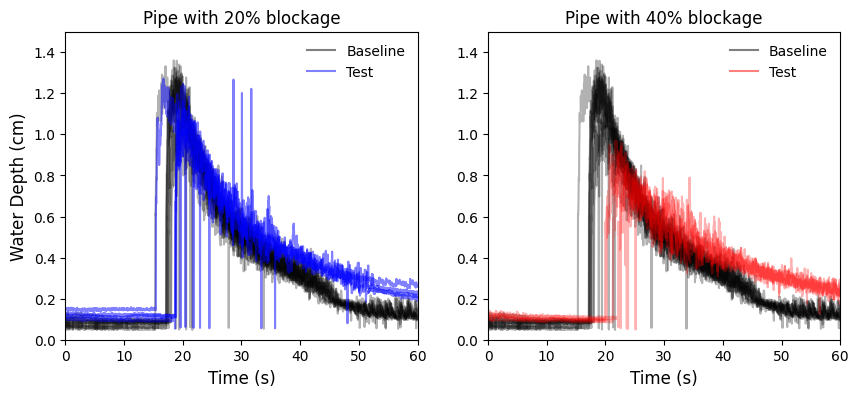

In [36]:
# Unaligned impulse and depth measurements.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai1_d'], 'k', alpha=0.3)
    ax2.plot(df['time'], df['V_ai1_d'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax1.plot(df['time'], df['V_ai1_d'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax2.plot(df['time'], df['V_ai1_d'], 'r', alpha=0.3)

ax1.plot([], [], 'k', alpha=0.5, label='Baseline')
ax1.plot([], [], 'b', alpha=0.5, label='Test')
ax2.plot([], [], 'k', alpha=0.5, label='Baseline')
ax2.plot([], [], 'r', alpha=0.5, label='Test')
ax1.legend(fontsize=10, frameon=False)
ax2.legend(fontsize=10, frameon=False)

ax1.set_xlim(0, 60)
ax1.set_ylim(0, 1.5)
ax2.set_xlim(0, 60)
ax2.set_ylim(0, 1.5)
ax1.set_title('Pipe with 20% blockage')
ax2.set_title('Pipe with 40% blockage')
ax1.set_xlabel('Time (s)', fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Water Depth (cm)', fontsize=12)

#### Zero out starting tank levels

Text(0, 0.5, 'Water Depth (cm)')

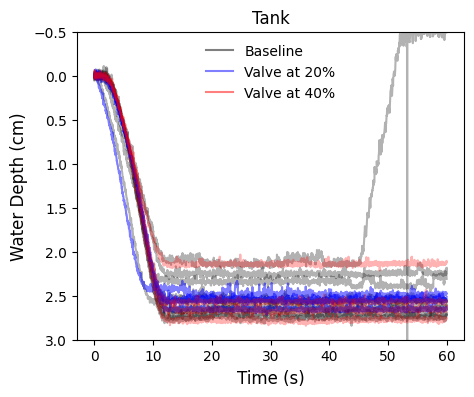

In [37]:
# Number of starting indices where tank is at "zero."
n_init = 20

# Baseline data frames.
for df in baseline_dfs:
    # Starting value is mean of first n_init values.
    V_init = df['V_ai2_h'].iloc[:n_init].mean()
    
    # Subtract out the initial voltage.
    V_zeroed = df['V_ai2_h'] - V_init

    # Substitute into new data frame.
    df['V_ai2_h_zero'] = V_zeroed

# Test data frames.
for df in test_20_dfs:
    # Starting value is mean of first n_init values.
    V_init = df['V_ai2_h'].iloc[:n_init].mean()
    
    # Subtract out the initial voltage.
    V_zeroed = df['V_ai2_h'] - V_init

    # Substitute into new data frame.
    df['V_ai2_h_zero'] = V_zeroed

# Test data frames.
for df in test_40_dfs:
    # Starting value is mean of first n_init values.
    V_init = df['V_ai2_h'].iloc[:n_init].mean()
    
    # Subtract out the initial voltage.
    V_zeroed = df['V_ai2_h'] - V_init

    # Substitute into new data frame.
    df['V_ai2_h_zero'] = V_zeroed

# Plot.
fig, ax1 = plt.subplots(figsize=(5,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai2_h_zero'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax1.plot(df['time'], df['V_ai2_h_zero'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax1.plot(df['time'], df['V_ai2_h_zero'], 'r', alpha=0.3)

# Legend plots.
ax1.plot([], [], 'k', alpha=0.5, label='Baseline')
ax1.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax1.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax1.legend(fontsize=10, frameon=False)

# ax1.set_xlim(0, 20)
ax1.set_ylim(-0.5, 3)
ax1.invert_yaxis()
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Water Depth (cm)', fontsize=12)

#### Align sensor readings based on head tank measurements.

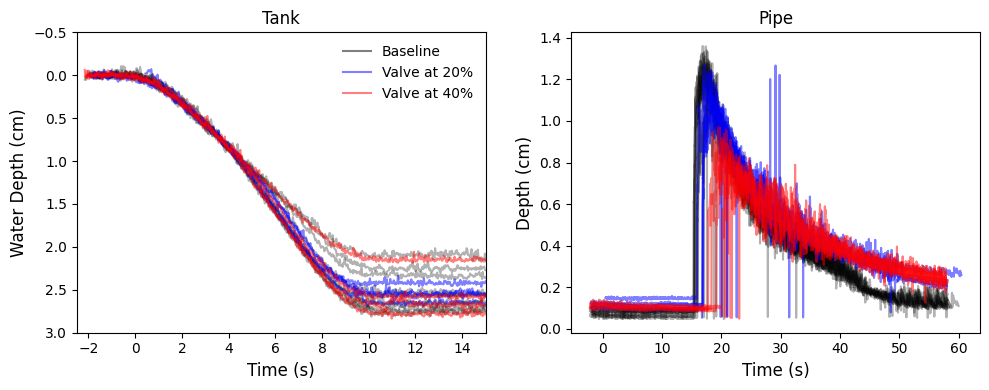

In [38]:
# Align all data frames to reference data frame based on head tank measurement column.

# Reference data frame.
df_ref = baseline_dfs[0]
df_ref['time_align'] = df_ref['time'] # This is the reference data frame so it doesn't need to be aligned.

# Align baseline data frames.
for df in baseline_dfs[1:]:
    t_align = align_measurements(df_ref, df, 'time', 'V_ai2_h_zero', 250)
    df['time_align'] = t_align

# Align test data frames.
for df in test_20_dfs:
    t_align = align_measurements(df_ref, df, 'time', 'V_ai2_h_zero', 250)
    df['time_align'] = t_align

for df in test_40_dfs:
    t_align = align_measurements(df_ref, df, 'time', 'V_ai2_h_zero', 250)
    df['time_align'] = t_align

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time_align'], df['V_ai2_h_zero'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax1.plot(df['time_align'], df['V_ai2_h_zero'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax1.plot(df['time_align'], df['V_ai2_h_zero'], 'r', alpha=0.5)

# Legend plots.
ax1.plot([], [], 'k', alpha=0.5, label='Baseline')
ax1.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax1.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax1.legend(fontsize=10, frameon=False)

ax1.set_xlim(-2.5, 15)
ax1.set_ylim(-0.5, 3)
ax1.invert_yaxis()
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Water Depth (cm)', fontsize=12)

# Depth in pipe.
for df in baseline_dfs:
    ax2.plot(df['time_align'], df['V_ai1_d'], 'k', alpha=0.3)

for df in test_20_dfs:
    ax2.plot(df['time_align'], df['V_ai1_d'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax2.plot(df['time_align'], df['V_ai1_d'], 'r', alpha=0.5)

# ax2.set_xlim(10, 25)
# ax2.set_ylim(4, 5)
ax2.set_title('Pipe')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Depth (cm)', fontsize=12)

fig.tight_layout()
# fig.savefig(r'C:\Users\ay434\Box\Research\Smart_Stormwater\DeFrees Lab System\Experiments\Figures\tank_sensor.png', dpi=300)

## Impulse

### Process raw tank measurement to flow.

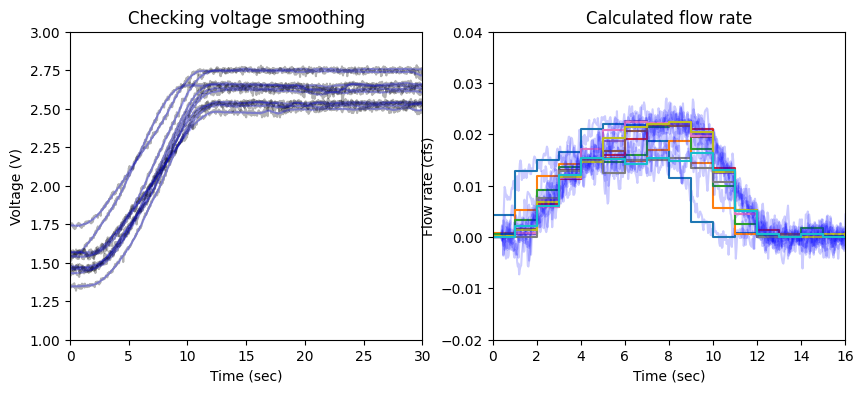

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Create array for baseline flow and datetime series dataframes.
baseline_fs = []

# Baseline data frames.
for df in baseline_dfs:
    # Tank voltage smoothing.
    window = 30
    V_tank = np.array(df['V_ai2'].rolling(window, center=True).mean().values)
    V_tank[np.isnan(V_tank)] = V_tank[16]

    # Times.
    t = df['time'].to_numpy()

    # Plot smoothed voltages
    ax1.plot(t, df['V_ai2'], 'k', alpha = 0.3)
    ax1.plot(t, V_tank, 'b', alpha = 0.3)
    ax1.set_xlim([0, 30])
    ax1.set_ylim([1, 3])
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_title('Checking voltage smoothing')
    
    # Calculate flow rate (continuous).
    Q = flow_rate(V_tank, t)

    # Convert Q to cubic ft per sec
    Q = Q*3.53147e-5

    # Add new column to df with Q values (mL/s).
    df['Q'] = Q

    # Plot flow rate.
    ax2.plot(t, Q, 'b', alpha = 0.2)
    ax2.set_xlim([0, 16])
    ax2.set_ylim([-0.02, 0.04])
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('Flow rate (cfs)')
    ax2.set_title('Calculated flow rate')

    # Calculate discrete flow series.
    (discrete_Q, datetimes) = discrete_flow_series(Q, t) 
    time_t = [sec.second for sec in datetimes]                 
    ax2.step(time_t, discrete_Q, where='post')                  

    # send discrete_Q to a dataframe and store in baseline_fs
    fs_df = pd.DataFrame({'discrete_Q': discrete_Q, 'datetimes': datetimes})
    baseline_fs.append(fs_df)

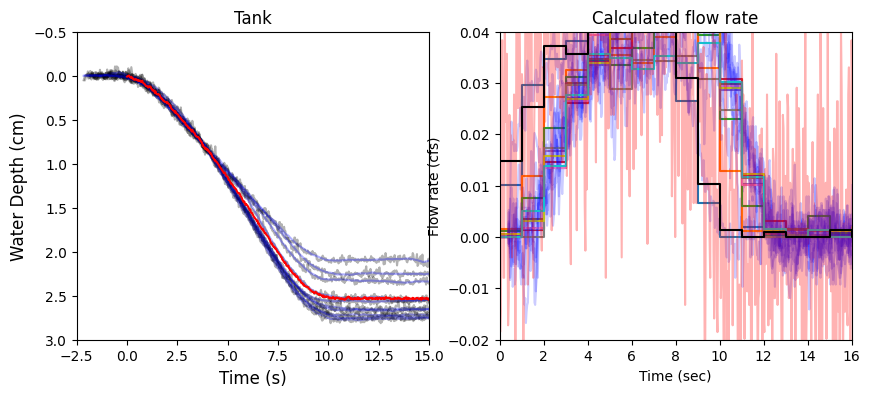

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# # Create array for baseline flow and datetime series dataframes.
# baseline_fs = []

# # Baseline data frames.
# for df in baseline_dfs:
#     # Tank voltage smoothing.
#     window = 30
#     V_tank = np.array(df['V_ai2_h_zero'].rolling(window, center=True).mean().values)
#     V_tank[np.isnan(V_tank)] = V_tank[16]

#     # Times.
#     t = df['time'].to_numpy()

#     # Plot smoothed voltages
#     ax1.plot(df['time_align'], df['V_ai2_h_zero'], 'k', alpha = 0.3)
#     ax1.plot(df['time_align'], V_tank, 'b', alpha = 0.3)
    
#     # Calculate flow rate (continuous).
#     Q = flow_rate(V_tank, t)

#     # Convert Q to cubic ft per sec
#     Q = Q*3.53147e-5

#     # Add new column to df with Q values (mL/s).
#     df['Q'] = Q

#     # Plot flow rate.
#     ax2.plot(t, Q, 'b', alpha = 0.2)

#     # Calculate discrete flow series.
#     (discrete_Q, datetimes) = discrete_flow_series(Q, t) 
#     time_t = [sec.second for sec in datetimes]                 
#     ax2.step(time_t, discrete_Q, where='post')                  

#     # send discrete_Q to a dataframe and store in baseline_fs
#     fs_df = pd.DataFrame({'discrete_Q': discrete_Q, 'datetimes': datetimes})
#     baseline_fs.append(fs_df)

# ax1.set_xlim(-2.5, 15)
# ax1.set_ylim(-0.5, 3)
# ax1.invert_yaxis()
# ax1.set_title('Tank')
# ax1.set_xlabel('Time (s)', fontsize=12)
# ax1.set_ylabel('Water Depth (cm)', fontsize=12)

# ax2.set_xlim([0, 16])
# ax2.set_ylim([-0.02, 0.04])
# ax2.set_xlabel('Time (sec)')
# ax2.set_ylabel('Flow rate (cfs)')
# ax2.set_title('Calculated flow rate')

# # take mean of aligned voltages (and plot)
# (mean_V, mean_t) = mean_reading(baseline_dfs, 'time_align', 'V_ai2_h_zero')
# ax1.plot(mean_t, mean_V, 'r')

# # calculate flow from mean voltages (and plot) # NOTE: CHANGE TO USE dh/dt instead of dV/dt -- current values wrong
# mean_Q = flow_rate(mean_V, mean_t)*3.53147e-5
# ax2.plot(mean_t, mean_Q, 'r', alpha = 0.3)
# (discrete_Q, datetimes) = discrete_flow_series(mean_Q, mean_t) 
# time_mean_t = np.array([sec.second for sec in datetimes])+mean_t[0]            
# ax2.step(time_mean_t, discrete_Q, where='post', color='k') 

# # Problem: aligning values may cut off early values, which makes the inflow time series less accurate at the beginning

### Convert to SWMM-readable impulse

In [51]:
# discretize flow from mean voltages
#(discrete_Q, datetimes) = discrete_flow_series(Q, t)

# OLD
k = 1
for fs in baseline_fs:
    path = Path(r"swmm_impulse_files")                          
    filename = f'impulse_file_baseline_{k}.dat'                                               
    flow_to_swmm_readable(fs['discrete_Q'], fs['datetimes'], path, filename)
    k += 1

# delete old files before running! This is the averaged impulse
path = Path(r"swmm_impulse_files")
filename = f'impulse_file_baseline.dat'
flow_to_swmm_readable(discrete_Q, datetimes, path, filename)

## SWMM simulation

### Load SWMM modeled depth

In [52]:
# Path to configuration file.
config_path = r"C:\Users\rabbi\OneDrive\Documents\GitHub\urbansurge\analysis\lab_system\SWMM\lab_system_SWMM_model_config.yml"
config_w = r"C:\Users\rabbi\OneDrive\Documents\GitHub\urbansurge\analysis\lab_system\SWMM\lab_system_SWMM_model_weir_config.yml"

# Create instance of SWMM model.
swmm = SWMM(config_path)
swmm_w = SWMM(config_w)

# Configure model.
swmm.configure_model()
swmm_w.configure_model()
swmm.run_simulation()
swmm_w.run_simulation()

# Extract depth at measurement link.
depth_df = swmm.get_node_depth()
depth_w = swmm_w.get_node_depth()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-01-01 00:00:00
Start Time: 2024-01-01 00:02:00
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-01-01 00:00:00
Start Time: 2024-01-01 00:02:00
INP PATH: C:\Users\rabbi\OneDrive\Documents\GitHub\urbansurge\analysis\lab_system\SWMM\lab_system_SWMM_model_tmp.inp
2024-01-01 00:00:00 , 0
2024-01-01 00:00:01 , 1
2024-01-01 00:00:02 , 2
2024-01-01 00:00:03 , 2
2024-01-01 00:00:04 , 3
2024-01-01 00:00:05 , 4
2024-01-01 00:00:06 , 5
2024-01-01 00:00:07 , 6
2024-01-01 00:00:08 , 7
2024-01-01 00:00:09 , 8
2024-01-01 00:00:10 , 8
2024-01-01 00:00:11 , 9
2024-01-01 00:00:12 , 10
2024-01-01 00:00:13 , 11
2024-01-01 00:00:14 , 12
2024-01-01 00:00:15 , 12
2024-01-01 00:00:16 , 13
2024-01-01 00:00:17 , 14
2024-01-01 00:00:18 , 15
2024-01-01 00:00:19 , 16
2024-01-01 00:00:20 , 17
2024-01-01 00:00:21 , 18
2024-01-01 00:00:22 , 18
2024-01-01 00:00:23 , 19
2024-01-01 00:00:24 , 20
2024-01-01 00:00:25 , 21
2024-01-01 00:00:26

### Plot SWMM modeled depth

Text(0.5, 1.0, 'SWMM Simulated, Weirs')

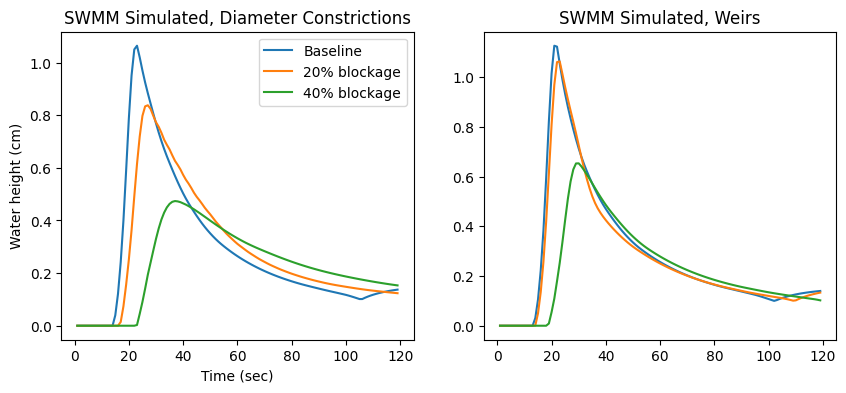

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

secs = np.array([sec.second for sec in depth_df['datetime']])
mins = np.array([min.minute for min in depth_df['datetime']])
times = 60*mins + secs

secs_w = np.array([sec.second for sec in depth_w['datetime']])
mins_w = np.array([min.minute for min in depth_w['datetime']])
times_w = 60*mins_w + secs_w

depths_baseline = depth_df['Depth_node_10']*30.48  # depth in cm
depths_20 = depth_df['Depth_node_12']*30.48
depths_40 = depth_df['Depth_node_29']*30.48

depths_baseline_w = depth_w['Depth_node_10']*30.48  # depth in cm
depths_20_w = depth_w['Depth_node_12']*30.48
depths_40_w = depth_w['Depth_node_29']*30.48

ax1.plot(times, depths_baseline)
ax1.plot(times, depths_20)
ax1.plot(times, depths_40)

ax2.plot(times_w, depths_baseline_w)
ax2.plot(times_w, depths_20_w)
ax2.plot(times_w, depths_40_w)

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Water height (cm)')
ax1.set_title('SWMM Simulated, Diameter Constrictions')
ax1.legend(['Baseline', '20% blockage', '40% blockage'])

ax2.set_title('SWMM Simulated, Weirs')


## Compare measured and modeled depths

### Diameter constriction: compare sensor measured heights to SWMM model results

(0.0, 60.0)

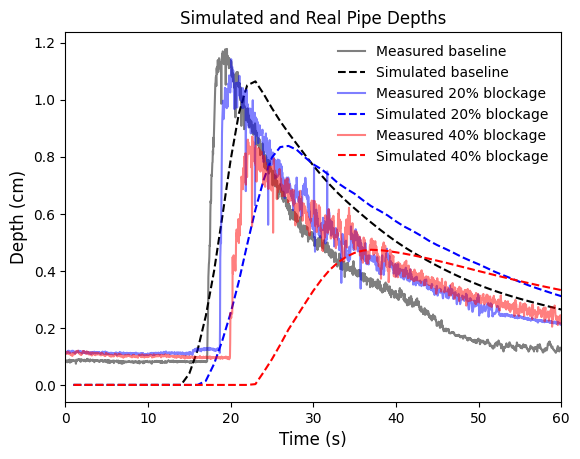

In [54]:
fig, ax = plt.subplots(1, 1)

# baseline
(mean_h, mean_t) = mean_reading(baseline_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t, mean_h, 'k', alpha = 0.5, label='Measured baseline')

ax.plot(times, depths_baseline, 'k--', label='Simulated baseline')

# 20% blockage
(mean_h20, mean_t20) = mean_reading(test_20_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t20, mean_h20, 'b', alpha = 0.5, label='Measured 20% blockage')

ax.plot(times, depths_20, 'b--', label='Simulated 20% blockage')

# 40% blockage

(mean_h40, mean_t40) = mean_reading(test_40_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t40, mean_h40, 'r', alpha = 0.5, label='Measured 40% blockage')

ax.plot(times, depths_40, 'r--', label='Simulated 40% blockage')

# plot formatting
ax.legend(fontsize=10, frameon=False)
ax.set_title('Simulated and Real Pipe Depths')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Depth (cm)', fontsize=12)
ax.set_xlim(0, 60)

### Weirs: compare sensor measured heights to SWMM model results

(0.0, 60.0)

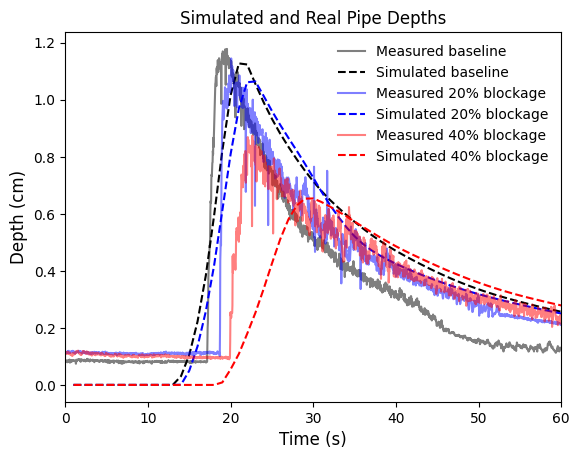

In [55]:
fig, ax = plt.subplots(1, 1)

# baseline
(mean_h, mean_t) = mean_reading(baseline_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t, mean_h, 'k', alpha = 0.5, label='Measured baseline')

ax.plot(times_w, depths_baseline_w, 'k--', label='Simulated baseline')

# 20% blockage
(mean_h20, mean_t20) = mean_reading(test_20_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t20, mean_h20, 'b', alpha = 0.5, label='Measured 20% blockage')

ax.plot(times_w, depths_20_w, 'b--', label='Simulated 20% blockage')

# 40% blockage

(mean_h40, mean_t40) = mean_reading(test_40_dfs, 'time', 'V_ai1_d')
ax.plot(mean_t40, mean_h40, 'r', alpha = 0.5, label='Measured 40% blockage')

ax.plot(times_w, depths_40_w, 'r--', label='Simulated 40% blockage')

# plot formatting
ax.legend(fontsize=10, frameon=False)
ax.set_title('Simulated and Real Pipe Depths')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Depth (cm)', fontsize=12)
ax.set_xlim(0, 60)

### Fault Detection

In [46]:
# Number of sensors.
n_sensor = 1

# Number of time steps.
Nt = baseline_dfs[0].shape[0] # Number of baseline time steps.

# Time steps.
dt = baseline_dfs[0]['time'][1] - baseline_dfs[0]['time'][0]
dts = [datetime.now() + timedelta(seconds=i*dt) for i in range(Nt)]

# Format baseline samples.
n_samp_base = len(baseline_dfs)
y_base = np.zeros((n_samp_base, Nt, 1))
for i, df in enumerate(baseline_dfs):
    y_base[i,:,:] = df['V_ai1_d'].to_numpy().reshape(-1,1)

# Format observation samples.
n_samp_test = len(test_20_dfs)
detections = []
moment_dicts = []
for i, df in enumerate(test_20_dfs):
    y_test = df['V_ai1_d'].to_numpy().reshape(1,-1)
    detect, moments = moment_fault_detect(dts, y_base, y_test, return_moments=True)
    detections.append(detect)
    moment_dicts.append(moments)

print(f'Detections: {detections}')

Detections: [True, True, True, True]


#### Arrival Time

In [47]:
def arrival_time(t, y):
    dt = t[1] - t[0]

    M0 = np.trapz(y, t)
    M1 = np.trapz(y * t, t)

    t_arrive = M1 / M0

    return t_arrive

df = baseline_dfs[2]
ta = arrival_time(df['time_align'], df['V_ai1_d'])

print(ta)

26.963190140489917


C:\Users\rabbi\AppData\Local\Temp\ipykernel_11532\4176849030.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M0 = np.trapz(y, t)
C:\Users\rabbi\AppData\Local\Temp\ipykernel_11532\4176849030.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M1 = np.trapz(y * t, t)


C:\Users\rabbi\AppData\Local\Temp\ipykernel_11532\4176849030.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M0 = np.trapz(y, t)
C:\Users\rabbi\AppData\Local\Temp\ipykernel_11532\4176849030.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M1 = np.trapz(y * t, t)


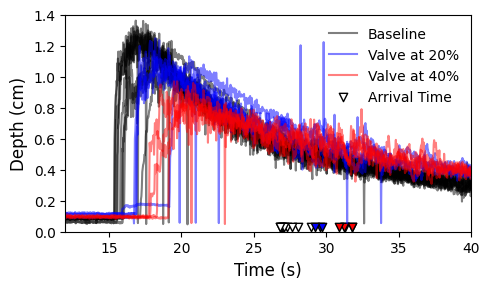

In [48]:
fig, ax = plt.subplots(figsize=(5,3))
for df in baseline_dfs:
    ax.plot(df['time_align'], df['V_ai1_d'], 'k', alpha=0.5)

for df in test_20_dfs:
    ax.plot(df['time_align'], df['V_ai1_d'], 'b', alpha=0.5)

for df in test_40_dfs:
    ax.plot(df['time_align'], df['V_ai1_d'], 'r', alpha=0.5)

for df in baseline_dfs:
    ta = arrival_time(df['time_align'], df['V_ai1_d'])
    ax.scatter(ta, 0.03, marker='v', edgecolors='k', facecolor='w')

for df in test_20_dfs:
    ta = arrival_time(df['time_align'], df['V_ai1_d'])
    ax.scatter(ta, 0.03, marker='v', edgecolors='k', facecolor='b')

for df in test_40_dfs:
    ta = arrival_time(df['time_align'], df['V_ai1_d'])
    ax.scatter(ta, 0.03, marker='v', edgecolors='k', facecolor='r')

# Legend Plots.
ax.plot([], [], 'k', alpha=0.5, label='Baseline')
ax.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax.scatter([], [], marker='v', edgecolors='k', facecolor='w', label='Arrival Time')
ax.legend(fontsize=10, frameon=False)

ax.set_ylim(0, 1.4)
ax.set_xlim(12, 40)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Depth (cm)', fontsize=12)

fig.tight_layout()
# fig.savefig(r'C:\Users\ay434\Box\Research\Smart_Stormwater\DeFrees Lab System\Experiments\Figures\arrival_time.png', dpi=300)

#### Drop-off

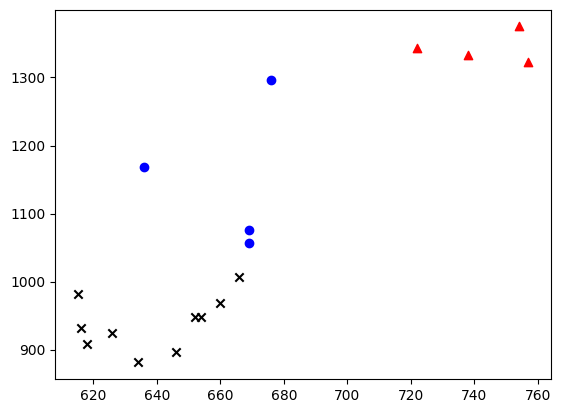

In [49]:
drop_frac = 0.5

fig, ax = plt.subplots()
for df in baseline_dfs:
    try:
        vals = df[f'V_ai1_d']
        max_val = np.max(vals)
        max_idx = np.argmax(vals)
        cross_idx = np.argwhere(vals > drop_frac* max_val)[-1]
        ax.scatter(max_idx, cross_idx, c='k', marker='x')
    except Exception as e:
        print(e)

for df in test_20_dfs:
    try:
        vals = df[f'V_ai1_d']
        max_val = np.max(vals)
        max_idx = np.argmax(vals)
        cross_idx = np.argwhere(vals > drop_frac * max_val)[-1]
        ax.scatter(max_idx, cross_idx, c='b')
    except Exception as e:
        print(e)

for df in test_40_dfs:
    try:
        vals = df[f'V_ai1_d']
        max_val = np.max(vals)
        max_idx = np.argmax(vals)
        cross_idx = np.argwhere(vals > drop_frac * max_val)[-1]
        ax.scatter(max_idx, cross_idx, c='r', marker='^')
    except Exception as e:
        print(e)

### Fault Diagnosis